# AIA Response Functions: Comparing SunPy and SSW Results

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import astropy.units as u
import ChiantiPy.tools.data as ch_data
import hissw

from sunpy.instr.aia.response import Response
from sunpy.instr.aia.response_utils import EmissTableInterface,aia_instr_properties_to_table,make_emiss_table

%matplotlib inline

## SSW Response Functions
Calculate the wavelength and temperature response functions using SSW.

In [6]:
ssw_script="""
; wavelength response
wresp = aia_get_response(/area,/dn,/timedepend_date,/evenorm)
wavelength = wresp.wave
wresponse_94 = wresp.a94.ea
wresponse_131 = wresp.a131.ea
wresponse_171 = wresp.a171.ea
wresponse_193 = wresp.a193.ea
wresponse_211 = wresp.a211.ea
wresponse_304 = wresp.a304.ea
wresponse_335 = wresp.a335.ea

; temperature response
tresp = aia_get_response(/temp,/dn,/timedepend_date,/evenorm)
temperature = 10.^tresp.logte
tresponse_94 = tresp.a94.tresp
tresponse_131 = tresp.a131.tresp
tresponse_171 = tresp.a171.tresp
tresponse_193 = tresp.a193.tresp
tresponse_211 = tresp.a211.tresp
tresponse_304 = tresp.a304.tresp
tresponse_335 = tresp.a335.tresp
"""

In [7]:
save_vars = ['temperature',
             'wavelength',
             'tresponse_94', 
             'tresponse_131',
             'tresponse_171',
             'tresponse_193',
             'tresponse_211',
             'tresponse_304',
             'tresponse_335',
             'wresponse_94', 
             'wresponse_131',
             'wresponse_171',
             'wresponse_193',
             'wresponse_211',
             'wresponse_304',
             'wresponse_335']

In [8]:
ssw_runner = hissw.ScriptMaker(ssw_pkg_list=['sdo/aia'],ssw_path_list=['aia'])

In [9]:
ssw_response_functions = ssw_runner.run([(ssw_script,{})],save_vars=save_vars,cleanup=True,verbose=True)

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ------------------------------
| $SSW/sdo/gen/idl/utilities   |
| $SSW/sdo/

## Detailed Channel Information
Note first that we can easily read detailed information about each of the AIA channels. Here, I've used instrument files from local SSW installation.

In [10]:
info_table = aia_instr_properties_to_table([94,131,171,193,211,335],
                        [os.path.join('/usr/local/ssw/','sdo/aia/response/aia_V6_all_fullinst.genx')])

In [11]:
info_table

channel,wavelength [8751],minimum_wavelength,wavelength_interval,number_wavelength_intervals,effective_area [8751],geometric_area_ccd,plate_scale,electron_per_dn,electron_per_ev,focal_plane_filter_efficiency [8751],entrance_filter_efficiency [8751],primary_mirror_reflectance [8751],secondary_mirror_reflectance [8751],quantum_efficiency_ccd [8751],ccd_contamination [8751]
Angstrom,Angstrom,Angstrom,Angstrom,,cm2,cm2,sr / pix,electron / ct,electron / eV,,,,,,
float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32
94.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,5.274892935641651e-12 .. 2.452600161807414e-14,83.0,8.461580394691914e-12,18.299999237060547,0.2739729881286621,0.0517922006547451 .. 1.0000100019169622e-06,0.0517922006547451 .. 1.0000100019169622e-06,5.367856374505209e-06 .. 0.08524589985609055,5.367856374505209e-06 .. 0.08524589985609055,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606
131.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,1.898906171193815e-10 .. 1.9013550499671905e-13,83.0,8.461580394691914e-12,17.600000381469727,0.2739729881286621,0.0517922006547451 .. 1.0000100019169622e-06,0.0517922006547451 .. 1.0000100019169622e-06,3.220666985725984e-05 .. 0.23735135793685913,3.220666985725984e-05 .. 0.23735135793685913,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606
171.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,4.4623433836932236e-08 .. 2.7117869061399347e-10,83.0,8.461580394691914e-12,17.700000762939453,0.2739729881286621,0.5954740047454834 .. 3.058119909837842e-05,0.5954740047454834 .. 3.058119909837842e-05,4.294149039196782e-05 .. 0.2931147813796997,4.294149039196782e-05 .. 0.2931147813796997,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606
193.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,0.0 .. 3.265265002827533e-10,83.0,8.461580394691914e-12,18.299999237060547,0.2739729881286621,0.5954740047454834 .. 3.058119909837842e-05,0.5954740047454834 .. 3.058119909837842e-05,0.0 .. 0.3216393291950226,0.0 .. 0.3216393291950226,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606
211.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,2.789005471015571e-09 .. 2.4803481490920376e-10,83.0,8.461580394691914e-12,18.299999237060547,0.2739729881286621,0.5954740047454834 .. 3.058119909837842e-05,0.5954740047454834 .. 3.058119909837842e-05,1.0735451724031009e-05 .. 0.28032785654067993,1.0735451724031009e-05 .. 0.28032785654067993,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606
335.0,25.0 .. 900.0,25.0,0.10000000149011612,8751.0,0.0 .. 1.1316664272342791e-10,83.0,8.461580394691914e-12,17.600000381469727,0.2739729881286621,0.5954740047454834 .. 3.058119909837842e-05,0.5954740047454834 .. 3.058119909837842e-05,0.0 .. 0.18935167789459229,0.0 .. 0.18935167789459229,0.8513820767402649 .. 0.09267791360616684,0.9657851457595825 .. 0.43874961137771606


## Wavelength Response Functions
Next, we'll actually instantiate the response object and calculate the wavelength response functions. We'll go ahead and calculate the response for all 7 EUV channels.

In [12]:
aia_response = Response()

When the `Response` object is instantiated, if no instrument files are supplied, it checks the the default SunPy downloads directory for the EUV and FUV instrument files. If they are not there, they are downloaded from the [Goddard SSW mirror](https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/response/). This way, a local installation of SSW is not needed. However, to calculate the temperature response functions, you'll need CHIANTI and ChiantiPy installed.

In [13]:
wavelength_response = aia_response.calculate_wavelength_response()

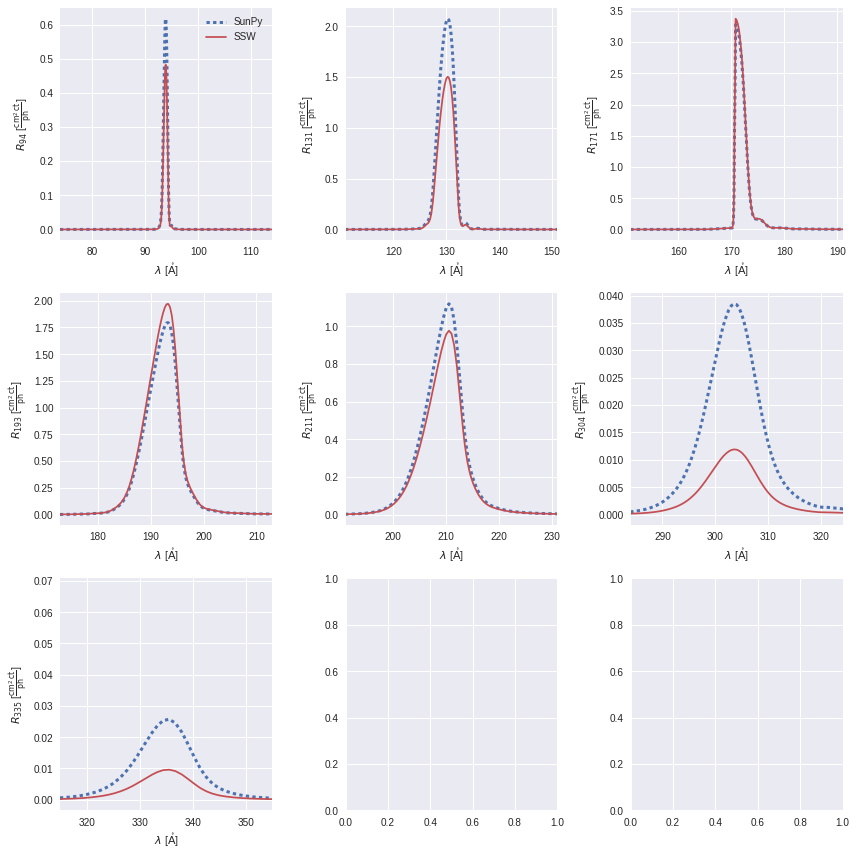

In [14]:
fig,axes = plt.subplots(3,3,figsize=(12,12))
for channel,ax in zip(sorted(wavelength_response.keys()),axes.flatten()):
    # sunpy
    ax.plot(wavelength_response[channel].wavelength,wavelength_response[channel].response,
            linestyle=':',lw=3,color=sns.color_palette('deep')[0],label='SunPy')
    # SSW
    ax.plot(ssw_response_functions['wavelength'],ssw_response_functions['wresponse_{}'.format(channel)],
            linestyle='-',color=sns.color_palette('deep')[2],label='SSW')
    ax.set_xlim([channel-20,channel+20])
    ax.set_xlabel(r'$\lambda$ [{:latex}]'.format(wavelength_response[channel].wavelength.unit))
    ax.set_ylabel(r'$R_{{{}}}$ [{:latex}]'.format(channel,wavelength_response[channel].response.unit))
axes[0,0].legend(loc='best')
plt.tight_layout()

Note that this shows the SSW AIA wavelength response functions with the time-dependent corrections so I guess we need to account for this somehow...

## Temperature Response Functions
Now, calculate the temperature response functions. The first time you do this, it will build an emissivity table which may take around 30 minutes, but this only needs to be done once. Alternatively, you can also build your own emissivity table using the built-in function. This is necessary if, for example, you want to change the abundances or ionization equilibrium file, or calculate over a different temperature/density range.

In [15]:
temperature_response = aia_response.calculate_temperature_response()

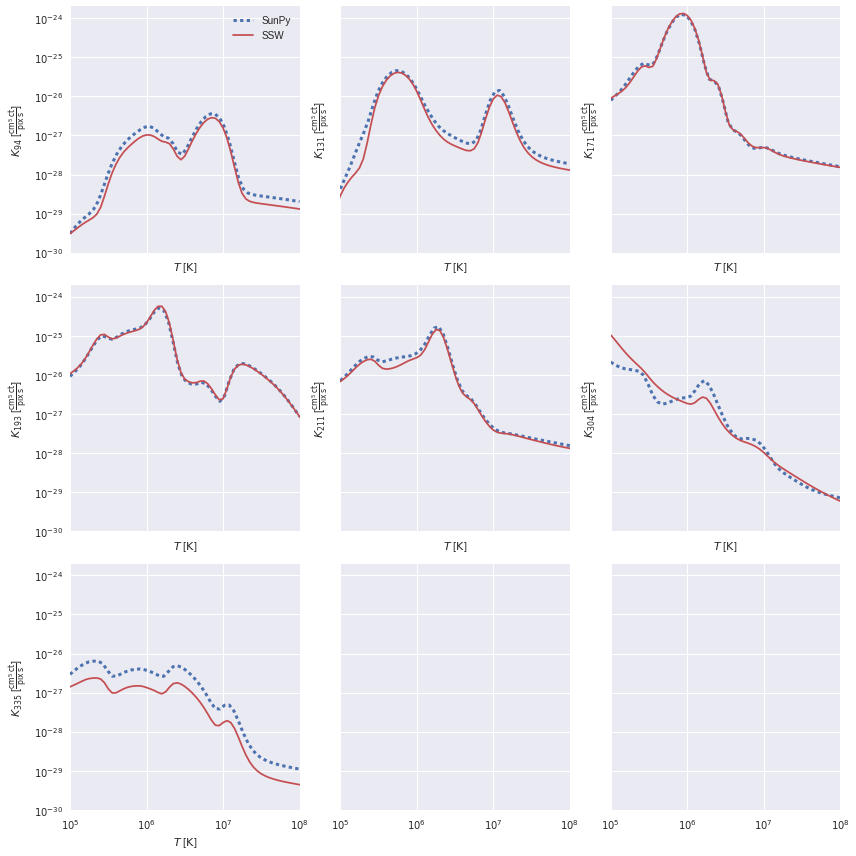

In [16]:
fig,axes = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)
for channel,ax in zip(sorted(wavelength_response.keys()),axes.flatten()):
    # sunpy
    ax.plot(temperature_response[channel].temperature,temperature_response[channel].response,
            linestyle=':',lw=3,color=sns.color_palette('deep')[0],label='SunPy')
    # SSW
    ax.plot(ssw_response_functions['temperature'],ssw_response_functions['tresponse_{}'.format(channel)],
            linestyle='-',color=sns.color_palette('deep')[2],label='SSW')
    ax.set_xlabel(r'$T$ [{:latex}]'.format(temperature_response[channel].temperature.unit))
    ax.set_ylabel(r'$K_{{{}}}$ [{:latex}]'.format(channel,temperature_response[channel].response.unit))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-30,2e-24])
    ax.set_xlim([1e5,1e8])
axes[0,0].legend(loc='best')
plt.tight_layout()

**Note that there is an issue with the 304 angstrom channel (even when the time-dependent correction to the wavelength response is not included). Perhaps there is some correction made in the 304 angstrom case, or ions that contribute in this wavlength range, that I've not accounted for here.**

Oddly, the lack of a time-dependent correction in the SunPy case actually gives better agreement between the two in the 304 angstrom case.

You can also choose the number of ions that you'd like to include in the temperature response function calculation. So for example if wanted to see how only including Fe ions affected the response functions,

In [17]:
fe_ions = [ion for ion in ch_data.MasterList if ion.split('_')[0]=='fe']

Or no Fe at all.

In [18]:
no_fe_ions = [ion for ion in ch_data.MasterList if ion.split('_')[0]!='fe']

In [19]:
temperature_response_fe_only = aia_response.calculate_temperature_response(ion_list=fe_ions)

In [20]:
temperature_response_no_fe = aia_response.calculate_temperature_response(ion_list=no_fe_ions)

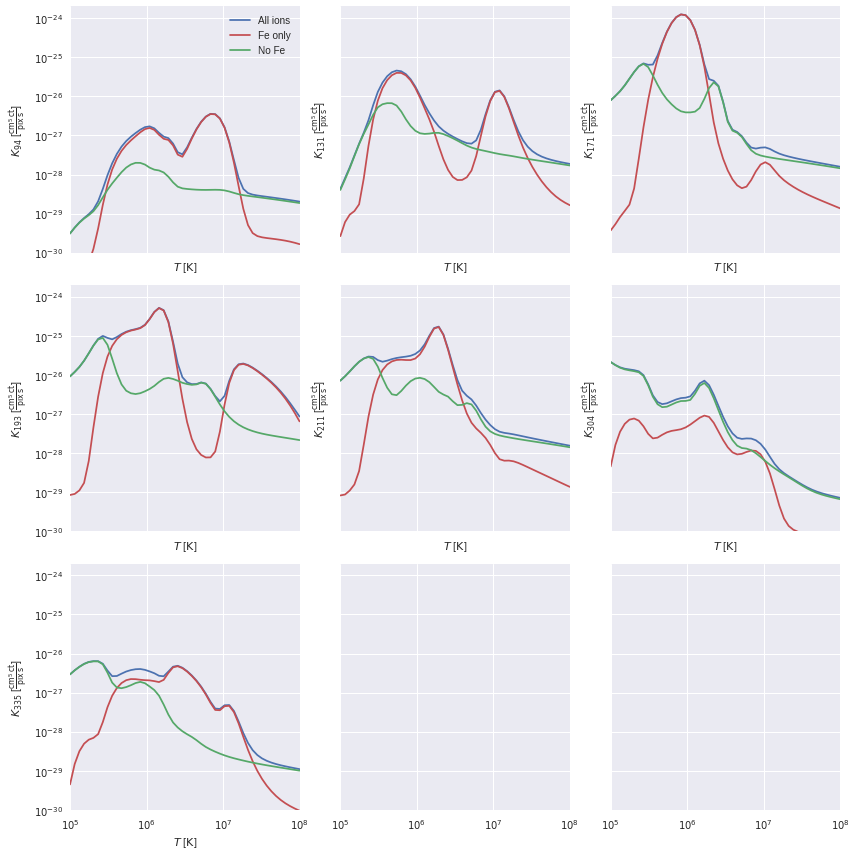

In [21]:
fig,axes = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)
for channel,ax in zip(sorted(wavelength_response.keys()),axes.flatten()):
    # all_ions
    ax.plot(temperature_response[channel].temperature,temperature_response[channel].response,
            linestyle='-',color=sns.color_palette('deep')[0],label='All ions')
    # Fe only
    ax.plot(temperature_response_fe_only[channel].temperature,
            temperature_response_fe_only[channel].response,
            linestyle='-',color=sns.color_palette('deep')[2],label='Fe only')
    # No Fe
    ax.plot(temperature_response_no_fe[channel].temperature,
            temperature_response_no_fe[channel].response,
            linestyle='-',color=sns.color_palette('deep')[1],label='No Fe')
    ax.set_xlabel(r'$T$ [{:latex}]'.format(temperature_response[channel].temperature.unit))
    ax.set_ylabel(r'$K_{{{}}}$ [{:latex}]'.format(channel,temperature_response[channel].response.unit))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-30,2e-24])
    ax.set_xlim([1e5,1e8])
axes[0,0].legend(loc='best')
plt.tight_layout()

## Calculating a Custom Emission Table
If you want to change the temperature/density/wavelength over which the emissivities are calculated or change things like the abundance, you can calculate your own emissivity table and then pass that file name in when calculating the temperature response functions.

In this short example, we'll calculate a new table using photospheric abundances, with constant density, and using only handful of ions with very high ionization states. To show the progress bar in the notebook, we need to pass in the `notebook=True` kwarg. Default is false and nothing will be displayed in notebook. For this to actually work though, you seem to need to have ipywidgets installed.

In [22]:
temperature = np.logspace(5.5,8,100)*u.K
density = 1e9*np.ones(temperature.shape)*u.cm**(-3)
abundance_file = 'sun_photospheric_1998_grevesse'
high_ionization_state_ions = [ion for ion in ch_data.MasterList if ion[-1] != 'd' and int(ion.split('_')[1]) >= 20]
emiss_table_filename = '/home/wtb2/Desktop/test_emiss_table.h5'

In [23]:
make_emiss_table(emiss_table_filename,ion_list=high_ionization_state_ions,temperature=temperature,density=density,
                 notebook=True, abundance_file=abundance_file)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [24]:
custom_temperature_response = aia_response.calculate_temperature_response(ion_list=high_ionization_state_ions,
                                                    emiss_table_file='/home/wtb2/Desktop/test_emiss_table.h5')

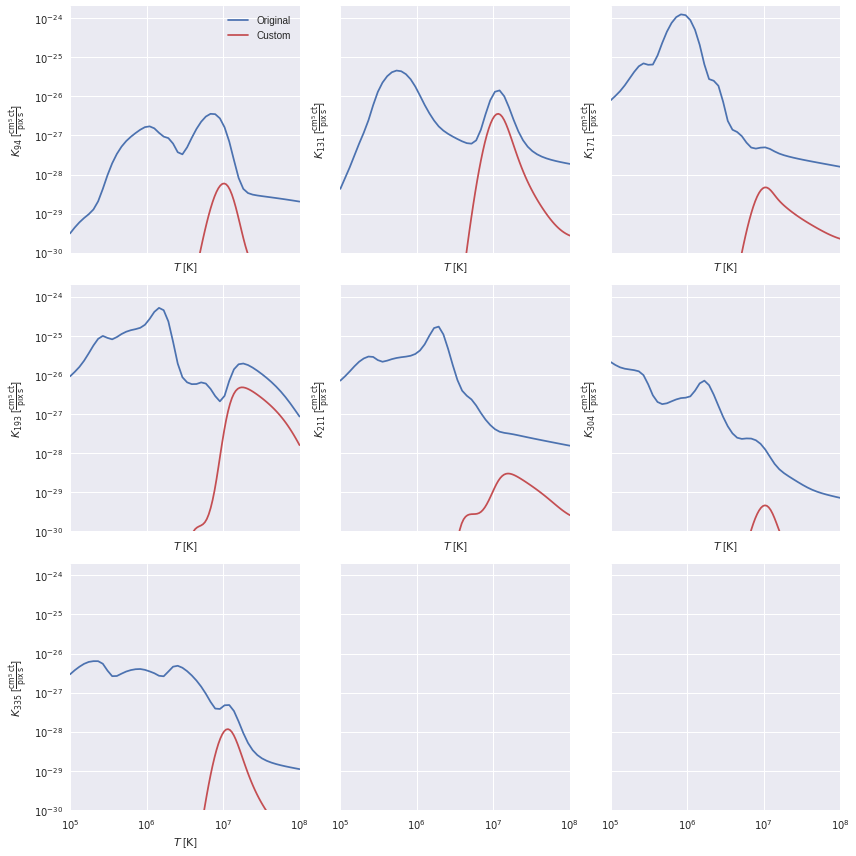

In [25]:
fig,axes = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)
for channel,ax in zip(sorted(wavelength_response.keys()),axes.flatten()):
    # all_ions
    ax.plot(temperature_response[channel].temperature,temperature_response[channel].response,
            linestyle='-',color=sns.color_palette('deep')[0],label='Original')
    # Fe only
    ax.plot(custom_temperature_response[channel].temperature,
            custom_temperature_response[channel].response,
            linestyle='-',color=sns.color_palette('deep')[2],label='Custom')
    ax.set_xlabel(r'$T$ [{:latex}]'.format(temperature_response[channel].temperature.unit))
    ax.set_ylabel(r'$K_{{{}}}$ [{:latex}]'.format(channel,temperature_response[channel].response.unit))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-30,2e-24])
    ax.set_xlim([1e5,1e8])
axes[0,0].legend(loc='best')
plt.tight_layout()

## Detailed Information about Emissivity Tables
The `EmissTableInterface` object provides a convenient way to inspect the different parts of the atomic data used to calculate the response functions, including the temperature, density, and line and continuum contributions.

In [26]:
emiss_table = EmissTableInterface('/home/wtb2/sunpy/data/aia_emiss_table.h5')

In [27]:
emiss_table.temperature

<Quantity [  1.00000000e+05,  1.15139540e+05,  1.32571137e+05,
             1.52641797e+05,  1.75751062e+05,  2.02358965e+05,
             2.32995181e+05,  2.68269580e+05,  3.08884360e+05,
             3.55648031e+05,  4.09491506e+05,  4.71486636e+05,
             5.42867544e+05,  6.25055193e+05,  7.19685673e+05,
             8.28642773e+05,  9.54095476e+05,  1.09854114e+06,
             1.26485522e+06,  1.45634848e+06,  1.67683294e+06,
             1.93069773e+06,  2.22299648e+06,  2.55954792e+06,
             2.94705170e+06,  3.39322177e+06,  3.90693994e+06,
             4.49843267e+06,  5.17947468e+06,  5.96362332e+06,
             6.86648845e+06,  7.90604321e+06,  9.10298178e+06,
             1.04811313e+07,  1.20679264e+07,  1.38949549e+07,
             1.59985872e+07,  1.84206997e+07,  2.12095089e+07,
             2.44205309e+07,  2.81176870e+07,  3.23745754e+07,
             3.72759372e+07,  4.29193426e+07,  4.94171336e+07,
             5.68986603e+07,  6.55128557e+07,  7.543120

In [28]:
emiss_table.density

<Quantity [  1.00000000e+10,  8.68511374e+09,  7.54312006e+09,
             6.55128557e+09,  5.68986603e+09,  4.94171336e+09,
             4.29193426e+09,  3.72759372e+09,  3.23745754e+09,
             2.81176870e+09,  2.44205309e+09,  2.12095089e+09,
             1.84206997e+09,  1.59985872e+09,  1.38949549e+09,
             1.20679264e+09,  1.04811313e+09,  9.10298178e+08,
             7.90604321e+08,  6.86648845e+08,  5.96362332e+08,
             5.17947468e+08,  4.49843267e+08,  3.90693994e+08,
             3.39322177e+08,  2.94705170e+08,  2.55954792e+08,
             2.22299648e+08,  1.93069773e+08,  1.67683294e+08,
             1.45634848e+08,  1.26485522e+08,  1.09854114e+08,
             9.54095476e+07,  8.28642773e+07,  7.19685673e+07,
             6.25055193e+07,  5.42867544e+07,  4.71486636e+07,
             4.09491506e+07,  3.55648031e+07,  3.08884360e+07,
             2.68269580e+07,  2.32995181e+07,  2.02358965e+07,
             1.75751062e+07,  1.52641797e+07,  1.325711

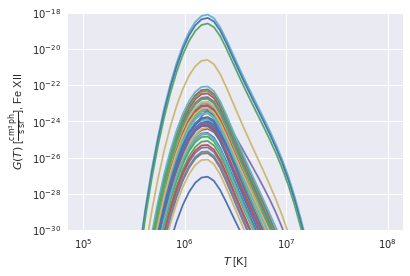

In [29]:
for i in range(emiss_table['fe_12'].contribution_function.shape[0]):
    plt.plot(emiss_table.temperature,emiss_table['fe_12'].contribution_function[:,i])
plt.xlabel(r'$T$ [{:latex}]'.format(emiss_table.temperature.unit))
plt.ylabel(r'$G(T)$ [{:latex}], Fe XII'.format(emiss_table['fe_12'].contribution_function.unit))
plt.ylim([1e-30,1e-18])
plt.yscale('log')
plt.xscale('log')